
# Kaggle: *I'm Something of a Painter Myself* — Monet Style GAN (CycleGAN)

## Project Overview

This notebook follows the **GAN Getting Started** competition on Kaggle, where the goal is to generate **7,000–10,000 Monet‑style images** at **256×256×3 (RGB)** and submit them as a single `images.zip` file.

**Evaluation:** Kaggle uses **MiFID** (Memorization‑informed Fréchet Inception Distance). Lower is better.  
**Data:** Monet paintings + photos (unpaired).  
**Model:** A compact **CycleGAN** (2 generators + 2 discriminators) with adversarial + cycle consistency + identity losses.

**Public GitHub Repo**: https://github.com/shaikh23/Monet-Gan-Kaggle/tree/main  




In [1]:

# --- Setup & Environment ---
import os, sys, glob, random, io, zipfile, math, time
from pathlib import Path

import numpy as np
import tensorflow as tf

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
try:
    import tensorflow_addons as tfa
    HAS_TFA = True
except Exception as e:
    HAS_TFA = False
print("Has tensorflow_addons:", HAS_TFA)

# TPU detection (optional)
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU:", resolver.master())
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Using TPU strategy")
except Exception as e:
    strategy = tf.distribute.get_strategy()  # default (CPU/GPU)
    print("Using default strategy:", type(strategy).__name__)


2025-09-18 19:24:07.956910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758223448.250537      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758223448.332346      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
GPU Available: []
Has tensorflow_addons: False
Using default strategy: _DefaultDistributionStrategy


2025-09-18 19:24:27.948593: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:

# --- Config ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

IMG_SIZE = 256
BATCH_SIZE = 1            # CycleGAN papers often use small batch sizes (1)
EPOCHS = 1
STEPS_PER_EPOCH = 150     # Keep small to fit a short first run; tune upward later

# Submission settings
NUM_SUBMIT_IMAGES = 7000  # Kaggle requires 7,000 - 10,000 images
SUBMISSION_ZIP = "images.zip"  # must be a single output file
SUBMISSION_DIR = "generated_images_tmp"

# Data discovery globs (Kaggle input paths)
# Competition input path is typically /kaggle/input/gan-getting-started
KAGGLE_INPUT_GUESS = "/kaggle/input"
COMP_NAME_HINT = "gan-getting-started"



## Data Discovery & Loading


In [3]:

def list_dir(p, max_depth=2):
    p = Path(p)
    for path in p.rglob("*"):
        rel = path.relative_to(p)
        depth = len(rel.parts)
        if depth <= max_depth:
            print(rel)

print("Scanning:", KAGGLE_INPUT_GUESS)
list_dir(KAGGLE_INPUT_GUESS, max_depth=3)

# Try to find plausible file groups
tfrec_candidates = sorted(glob.glob(f"{KAGGLE_INPUT_GUESS}/**/*.tfrec*", recursive=True))
jpg_dirs = [d for d in glob.glob(f"{KAGGLE_INPUT_GUESS}/**/", recursive=True)
            if any(x in d.lower() for x in ["monet", "photo", "jpg"]) and ("__MACOSX" not in d)]

print("\nFound TFRecord files:", len(tfrec_candidates))
print("\nSample TFRecord paths:")
for p in tfrec_candidates[:6]:
    print("  ", p)

print("\nCandidate JPG folders:")
for d in jpg_dirs[:8]:
    print("  ", d)


Scanning: /kaggle/input
gan-getting-started
gan-getting-started/monet_jpg
gan-getting-started/photo_tfrec
gan-getting-started/photo_jpg
gan-getting-started/monet_tfrec
gan-getting-started/monet_jpg/f4413e97bd.jpg
gan-getting-started/monet_jpg/7341d96c1d.jpg
gan-getting-started/monet_jpg/de6f71b00f.jpg
gan-getting-started/monet_jpg/99d94af5dd.jpg
gan-getting-started/monet_jpg/99a51d3e25.jpg
gan-getting-started/monet_jpg/d05cab011d.jpg
gan-getting-started/monet_jpg/4e05523825.jpg
gan-getting-started/monet_jpg/c68c52e8fc.jpg
gan-getting-started/monet_jpg/40d7d18ad3.jpg
gan-getting-started/monet_jpg/f96a8de9f3.jpg
gan-getting-started/monet_jpg/79224da51f.jpg
gan-getting-started/monet_jpg/23832dead5.jpg
gan-getting-started/monet_jpg/85580214be.jpg
gan-getting-started/monet_jpg/47a0548067.jpg
gan-getting-started/monet_jpg/fb93438ff9.jpg
gan-getting-started/monet_jpg/89d970411d.jpg
gan-getting-started/monet_jpg/7960adbd50.jpg
gan-getting-started/monet_jpg/baf6efabfe.jpg
gan-getting-started/mo

In [4]:

# --- TFRecord Parsing Utilities ---
# Kaggle forks encode images under a single 'image' bytes feature.

feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_tfrecord(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.image.decode_jpeg(example['image'], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0..1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = (img * 2.0) - 1.0  # scale to [-1, 1]
    return img

def load_tfrec_dataset(filepaths, shuffle=False, repeat=False):
    if not filepaths:
        return None
    ds = tf.data.TFRecordDataset(filepaths, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(_parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

# JPG folder loader (fallback or EDA)
def load_jpg_folder(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.jpg"))) + sorted(glob.glob(os.path.join(folder, "*.jpeg")))
    if not files:
        return None
    def _gen():
        for f in files:
            img = tf.io.read_file(f)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = (img * 2.0) - 1.0
            yield img
    ds = tf.data.Dataset.from_generator(_gen, output_signature=tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32))
    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds


In [5]:

# --- Attempt to locate Monet and Photo datasets ---

def _split_by_keyword(paths, positive_kw, negative_kw=None):
    positive = []
    for p in paths:
        low = p.lower()
        if any(k in low for k in positive_kw):
            if not negative_kw or not any(k in low for k in negative_kw):
                positive.append(p)
    return sorted(positive)

monet_tfrec = _split_by_keyword(tfrec_candidates, ["monet"])
photo_tfrec = _split_by_keyword(tfrec_candidates, ["photo"])

print(f"Found Monet TFRecords: {len(monet_tfrec)}")
print(f"Found Photo TFRecords: {len(photo_tfrec)}")

monet_ds = load_tfrec_dataset(monet_tfrec, shuffle=True, repeat=True) if monet_tfrec else None
photo_ds = load_tfrec_dataset(photo_tfrec, shuffle=True, repeat=True) if photo_tfrec else None

# If TFRecords missing, try JPGs
if monet_ds is None:
    monet_jpg_folders = [d for d in jpg_dirs if "monet" in d.lower()]
    if monet_jpg_folders:
        monet_ds = load_jpg_folder(monet_jpg_folders[0])
        print("Loaded Monet JPGs from:", monet_jpg_folders[0])

if photo_ds is None:
    photo_jpg_folders = [d for d in jpg_dirs if "photo" in d.lower()]
    if photo_jpg_folders:
        photo_ds = load_jpg_folder(photo_jpg_folders[0])
        print("Loaded Photos JPGs from:", photo_jpg_folders[0])

if monet_ds is None or photo_ds is None:
    print("\n Could not auto-locate both Monet and Photo datasets.")
    print("Review the printed directory structure above and adjust the discovery/globs if needed.")
else:
    print("\n Datasets ready.")


Found Monet TFRecords: 5
Found Photo TFRecords: 20

 Datasets ready.



### Quick EDA: 

Visualize a few samples (scaled back to [0,1] for display).

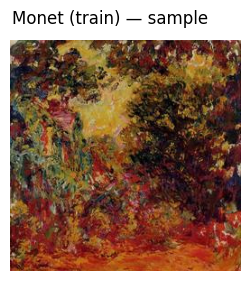

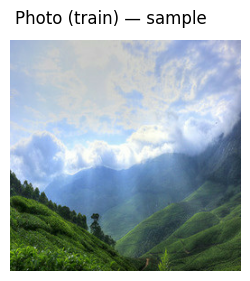

In [6]:

import matplotlib.pyplot as plt

def denorm(x):
    return (x + 1.0) * 0.5

def show_batch(ds, title, n=6):
    if ds is None:
        print(f"[{title}] dataset is None — skip")
        return
    batch = next(iter(ds.take(1)))
    imgs = batch.numpy()
    plt.figure(figsize=(12, 3))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(1, min(n, imgs.shape[0]), i+1)
        plt.imshow(denorm(imgs[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_batch(monet_ds, "Monet (train) — sample")
show_batch(photo_ds, "Photo (train) — sample")



## Model: Compact CycleGAN

Implement a light CycleGAN:

- **Generators**: ResNet blocks with reflection padding + instance normalization (custom fallback if TFA is unavailable)  
- **Discriminators**: 70×70 PatchGAN  
- **Losses**: LSGAN adversarial + cycle consistency (lambda=10) + identity (lambda=5)


In [7]:

from tensorflow.keras import layers, Model

# --- Reflection padding layer ---
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1,1), **kwargs):
        super().__init__(**kwargs)
        if isinstance(padding, int):
            padding = (padding, padding)
        self.padding = padding
    def call(self, x):
        p_h, p_w = self.padding
        return tf.pad(x, [[0,0],[p_h,p_h],[p_w,p_w],[0,0]], mode='REFLECT')

# --- Instance Norm (use TFA if available) ---
if HAS_TFA:
    InstanceNorm = tfa.layers.InstanceNormalization
else:
    class InstanceNorm(layers.Layer):
        def __init__(self, epsilon=1e-5, **kwargs):
            super().__init__(**kwargs)
            self.epsilon = epsilon
        def build(self, input_shape):
            self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
            self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        def call(self, x):
            mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
            x_norm = (x - mean) / tf.sqrt(var + self.epsilon)
            return self.gamma * x_norm + self.beta

def resnet_block(x, filters, name):
    y = ReflectionPadding2D(1, name=name+"_pad1")(x)
    y = layers.Conv2D(filters, 3, padding='valid', name=name+"_conv1")(y)
    y = InstanceNorm(name=name+"_in1")(y)
    y = layers.ReLU()(y)

    y = ReflectionPadding2D(1, name=name+"_pad2")(y)
    y = layers.Conv2D(filters, 3, padding='valid', name=name+"_conv2")(y)
    y = InstanceNorm(name=name+"_in2")(y)

    return layers.Add()([x, y])

def build_generator(img_size=256, n_res_blocks=6, name="G"):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = ReflectionPadding2D(3, name=name+"_inpad")(inputs)
    x = layers.Conv2D(64, 7, padding='valid', name=name+"_c7s1_64")(x)
    x = InstanceNorm(name=name+"_in0")(x)
    x = layers.ReLU()(x)

    # downsample
    for i, f in enumerate([128, 256]):
        x = layers.Conv2D(f, 3, strides=2, padding='same', name=f"{name}_d{i+1}_{f}")(x)
        x = InstanceNorm(name=f"{name}_in_d{i+1}")(x)
        x = layers.ReLU()(x)

    # residual blocks
    for i in range(n_res_blocks):
        x = resnet_block(x, 256, name=f"{name}_res{i+1}")

    # upsample
    for i, f in enumerate([128, 64]):
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same', name=f"{name}_u{i+1}_{f}")(x)
        x = InstanceNorm(name=f"{name}_in_u{i+1}")(x)
        x = layers.ReLU()(x)

    x = ReflectionPadding2D(3, name=name+"_outpad")(x)
    x = layers.Conv2D(3, 7, padding='valid', activation='tanh', name=name+"_out")(x)
    return Model(inputs, x, name=name)

def build_discriminator(img_size=256, name="D"):
    def conv_bn_lrelu(x, f, s, n):
        x = layers.Conv2D(f, 4, strides=s, padding='same', name=f"{name}_conv{n}")(x)
        if n > 1:
            x = InstanceNorm(name=f"{name}_in{n}")(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = conv_bn_lrelu(inputs, 64, 2, 1)
    x = conv_bn_lrelu(x, 128, 2, 2)
    x = conv_bn_lrelu(x, 256, 2, 3)
    x = conv_bn_lrelu(x, 512, 1, 4)  # PatchGAN head

    x = layers.Conv2D(1, 4, padding='same', name=f"{name}_out")(x)
    return Model(inputs, x, name=name)

with strategy.scope():
    G_XtoY = build_generator(IMG_SIZE, n_res_blocks=6, name="G_XtoY")  # Photos -> Monet
    G_YtoX = build_generator(IMG_SIZE, n_res_blocks=6, name="G_YtoX")  # Monet  -> Photos
    D_X = build_discriminator(IMG_SIZE, name="D_X")  # Real/fake in domain X (Photos)
    D_Y = build_discriminator(IMG_SIZE, name="D_Y")  # Real/fake in domain Y (Monet)

    # Optimizers
    gen_lr = 2e-4
    disc_lr = 2e-4
    G_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.5)
    F_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.5)
    DX_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.5)
    DY_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.5)

# Loss functions: LSGAN
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0

def generator_loss_gan(fake_logits):
    # LSGAN: target = 1 for generated
    return mse(tf.ones_like(fake_logits), fake_logits)

def discriminator_loss_gan(real_logits, fake_logits):
    real_loss = mse(tf.ones_like(real_logits), real_logits)
    fake_loss = mse(tf.zeros_like(fake_logits), fake_logits)
    return 0.5 * (real_loss + fake_loss)

@tf.function
def train_step(batch_X, batch_Y):
    # X: Photos, Y: Monet
    with tf.GradientTape(persistent=True) as tape:
        # Generators
        fake_Y = G_XtoY(batch_X, training=True)
        cycled_X = G_YtoX(fake_Y, training=True)

        fake_X = G_YtoX(batch_Y, training=True)
        cycled_Y = G_XtoY(fake_X, training=True)

        # Identity (optional but helps)
        same_Y = G_XtoY(batch_Y, training=True)
        same_X = G_YtoX(batch_X, training=True)

        # Discriminators
        disc_real_X = D_X(batch_X, training=True)
        disc_real_Y = D_Y(batch_Y, training=True)

        disc_fake_X = D_X(fake_X, training=True)
        disc_fake_Y = D_Y(fake_Y, training=True)

        # Losses
        gen_XtoY_gan = generator_loss_gan(disc_fake_Y)
        gen_YtoX_gan = generator_loss_gan(disc_fake_X)

        cycle_loss = mae(batch_X, cycled_X) + mae(batch_Y, cycled_Y)
        id_loss = mae(batch_Y, same_Y) + mae(batch_X, same_X)

        gen_total_XtoY = gen_XtoY_gan + LAMBDA_CYCLE * cycle_loss + LAMBDA_ID * id_loss
        gen_total_YtoX = gen_YtoX_gan + LAMBDA_CYCLE * cycle_loss + LAMBDA_ID * id_loss

        disc_X_loss = discriminator_loss_gan(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss_gan(disc_real_Y, disc_fake_Y)

    # Gradients & updates
    grads_G = tape.gradient(gen_total_XtoY, G_XtoY.trainable_variables)
    grads_F = tape.gradient(gen_total_YtoX, G_YtoX.trainable_variables)
    grads_DX = tape.gradient(disc_X_loss, D_X.trainable_variables)
    grads_DY = tape.gradient(disc_Y_loss, D_Y.trainable_variables)

    G_optimizer.apply_gradients(zip(grads_G, G_XtoY.trainable_variables))
    F_optimizer.apply_gradients(zip(grads_F, G_YtoX.trainable_variables))
    DX_optimizer.apply_gradients(zip(grads_DX, D_X.trainable_variables))
    DY_optimizer.apply_gradients(zip(grads_DY, D_Y.trainable_variables))

    return {
        "G_XtoY": gen_total_XtoY,
        "G_YtoX": gen_total_YtoX,
        "D_X": disc_X_loss,
        "D_Y": disc_Y_loss,
        "cycle": cycle_loss,
        "id": id_loss,
        "gan_xy": gen_XtoY_gan,
        "gan_yx": gen_YtoX_gan,
    }



### Training

Keep epochs and steps small. Once everything runs end‑to‑end is confirmed,
increase `EPOCHS` and `STEPS_PER_EPOCH` to improve image quality (and MiFID).


In [8]:

if (monet_ds is None) or (photo_ds is None):
    print("Skipping training because datasets are missing.")
else:
    # Prepare iterators for a fixed number of steps per epoch
    monet_iter = iter(monet_ds)
    photo_iter = iter(photo_ds)

    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        loss_acc = {"G_XtoY":0.,"G_YtoX":0.,"D_X":0.,"D_Y":0.,"cycle":0.,"id":0.,"gan_xy":0.,"gan_yx":0.}
        for step in range(1, STEPS_PER_EPOCH+1):
            try:
                batch_Y = next(monet_iter)
            except StopIteration:
                monet_iter = iter(monet_ds); batch_Y = next(monet_iter)
            try:
                batch_X = next(photo_iter)
            except StopIteration:
                photo_iter = iter(photo_ds); batch_X = next(photo_iter)

            metrics = train_step(batch_X, batch_Y)
            for k in loss_acc:
                loss_acc[k] += float(tf.reduce_mean(metrics[k]))

            if step % 50 == 0:
                print(f"Epoch {epoch}/{EPOCHS} Step {step}/{STEPS_PER_EPOCH} "
                      f"Gxy:{metrics['gan_xy']:.3f} Gyx:{metrics['gan_yx']:.3f} "
                      f"Dx:{metrics['D_X']:.3f} Dy:{metrics['D_Y']:.3f} "
                      f"cyc:{metrics['cycle']:.3f} id:{metrics['id']:.3f}")
        dt = time.time() - t0
        for k in loss_acc:
            loss_acc[k] /= STEPS_PER_EPOCH
        print(f"Epoch {epoch} done in {dt:.1f}s | Averages:", {k: round(v,3) for k,v in loss_acc.items()})


Epoch 1/1 Step 50/150 Gxy:0.341 Gyx:0.316 Dx:0.352 Dy:0.311 cyc:0.618 id:0.574
Epoch 1/1 Step 100/150 Gxy:0.385 Gyx:0.347 Dx:0.296 Dy:0.260 cyc:0.795 id:0.725
Epoch 1/1 Step 150/150 Gxy:0.560 Gyx:0.234 Dx:0.254 Dy:0.239 cyc:1.284 id:1.209
Epoch 1 done in 3498.9s | Averages: {'G_XtoY': 10.285, 'G_YtoX': 10.242, 'D_X': 0.494, 'D_Y': 0.496, 'cycle': 0.66, 'id': 0.633, 'gan_xy': 0.519, 'gan_yx': 0.477}



## Inference & Submission (`images.zip`)



In [9]:

def tensor_to_jpg_bytes(t):
    # t in [-1,1] -> uint8 0..255
    t = tf.squeeze(t, axis=0) if len(t.shape) == 4 else t  # remove batch if present
    img01 = (t + 1.0) * 0.5
    img01 = tf.clip_by_value(img01, 0.0, 1.0)
    img255 = tf.cast(img01 * 255.0, tf.uint8)
    jpg = tf.io.encode_jpeg(img255)
    return bytes(jpg.numpy())

def generate_submission_zip(generator, source_ds, num_images=7000, zip_name=SUBMISSION_ZIP):
    if source_ds is None:
        print("Source dataset is None; cannot generate submission.")
        return
    # We'll use an iterator and cycle as needed
    it = iter(source_ds.repeat())
    count = 0
    with zipfile.ZipFile(zip_name, mode='w', compression=zipfile.ZIP_STORED) as zf:
        while count < num_images:
            batch = next(it)
            # batch shape [B, H, W, 3] in [-1,1]
            outs = generator(batch, training=False)
            for i in range(outs.shape[0]):
                if count >= num_images: break
                jpg_bytes = tensor_to_jpg_bytes(outs[i])
                # Name images as 0.jpg, 1.jpg, ...
                zf.writestr(f"{count}.jpg", jpg_bytes)
                count += 1
            if count % 500 == 0:
                print(f"Wrote {count}/{num_images} images to {zip_name}")
    print(f" Done: {zip_name} with {num_images} images.")

# Generate Monet-style images from Photos -> Monet (G_XtoY)
if photo_ds is None:
    print(" Skip submission creation: photo_ds missing.")
else:
    generate_submission_zip(G_XtoY, photo_ds, num_images=NUM_SUBMIT_IMAGES, zip_name=SUBMISSION_ZIP)



Wrote 500/7000 images to images.zip
Wrote 1000/7000 images to images.zip
Wrote 1500/7000 images to images.zip
Wrote 2000/7000 images to images.zip
Wrote 2500/7000 images to images.zip
Wrote 3000/7000 images to images.zip
Wrote 3500/7000 images to images.zip
Wrote 4000/7000 images to images.zip
Wrote 4500/7000 images to images.zip
Wrote 5000/7000 images to images.zip
Wrote 5500/7000 images to images.zip
Wrote 6000/7000 images to images.zip
Wrote 6500/7000 images to images.zip
Wrote 7000/7000 images to images.zip
 Done: images.zip with 7000 images.
